In [1]:
# This cell holds the code for styling the jupyter notebook.
# This cell should be ignored, this doesn't contain anything related to Credit Scoring System

import urllib.request as req
from IPython.core.display import HTML

response_main = req.urlopen('https://raw.githubusercontent.com/sprakshith/TechDeciphersStyles/main/static/main.css')
response_theme = req.urlopen('https://raw.githubusercontent.com/sprakshith/TechDeciphersStyles/main/static/dynamic_colors.css')

response_theme_string = response_theme.read().decode('utf-8')
response_theme_string = response_theme_string.replace('[#COLOR_ONE#]', '#ADD8E6')
response_theme_string = response_theme_string.replace('[#COLOR_TWO#]', '#101820')
response_theme_string = response_theme_string.replace('[#COLOR_THREE#]', '#2F3C7E')

HTML('<style>' + response_main.read().decode('utf-8') + response_theme_string + '</style>')

---
<h1 class="content-header">Credit Scoring Dataset EDA and Prediction by Group 1</h1>

<div style="text-align: center;">
    <img src="https://time.com/personal-finance/static/eae579cd0af2665560dfa3f49bf82ee7/57e17/Increase-credit-score.jpg" alt="Sorry, no image," style="height:450px;"/>
</div>

<h2 class="content-header">Table of Contents</h2>

<ul class="table-of-content-list">
    <li><a href="#1">1. Importing the Required Libraries and Defining Helper Functions</a></li>
    <li>
        <a href="#2">2. Importing data and Initial Lookup at the Data</a>
        <ul>
            <li><a href="#2.1">2.1 Description of each Column</a></li>
            <li><a href="#2.2">2.2 Checking for missing values in the dataset</a></li>
        </ul>
    </li>
    <li>
        <a href="#3">3. Data Preprocessing for Exploratory Data Analysis</a>
        <ul>
            <li><a href="#3.1">3.1 Subsection 1</a></li>
            <li><a href="#3.2">3.2 Subsection 2</a></li>
            <li><a href="#3.3">3.3 Subsection 3</a></li>
        </ul>
    </li>
    <li>
        <a href="#4">4. Exploratory Data Analysis</a>
        <ul>
            <li><a href="#4.1">4.1 Subsection 1</a></li>
            <li><a href="#4.2">4.2 Subsection 2</a></li>
            <li><a href="#4.3">4.3 Subsection 3</a></li>
        </ul>
    </li>
    <li>
        <a href="#5">5. Training a Prediction Model</a>
        <ul>
            <li><a href="#5.1">5.1 Data Preprocessing for Prediction</a></li>
            <li><a href="#5.2">5.2 Training and Evaluating few Classification Models</a></li>
            <li><a href="#5.3">5.3 Plotting ROC Curve for each Model</a></li>
        </ul>
    </li>
    <li>
        <a href="#6">6. SHAP-driven Insights from RandomForest Classifier</a>
        <ul>
            <li><a href="#6.1">6.1 Subsection 1</a></li>
            <li><a href="#6.2">6.2 Subsection 2</a></li>
            <li><a href="#6.3">6.3 Subsection 3</a></li>
        </ul>
    </li>
    <li><a href="#7">7. Conclustion</a></li>
</ul>

---
<a id="1"></a>
<h3 class="content-header">1. Importing the Required Libraries and Defining Helper Functions</h3>

In [2]:
import warnings 
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

%matplotlib inline

In [3]:
def extract_int(s):
    if pd.isna(s):
        return s

    return int(re.sub(r"[^0-9]", "", s))

def extract_float(s):
    if pd.isna(s):
        return s
    
    return float(re.sub(r"[^0-9.]", "", s))

def extract_months(value):
    if pd.isna(value):
        return value
    match = re.match(r'(\d+)\s*Years\s*and\s*(\d+)\s*Months', value)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years * 12 + months
    return value

def plot_boxplot(before, after):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    before.plot(kind='box', ax=axes[0])
    axes[0].set_title('Before Cleaning')
    after.plot(kind='box', ax=axes[1])
    axes[1].set_title('After Cleaning')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(models, model_names):
    n_classes = len(np.unique(y_test))
    lw = 2

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    for ax, model, name in zip(axes.ravel(), models, model_names):
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        y_score = model.predict_proba(X_test)
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        colors = plt.cm.jet(np.linspace(0, 1, n_classes))
        
        for i, color in zip(range(n_classes), colors):
            ax.plot(fpr[i], tpr[i], color=color, lw=lw,
                    label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

        ax.plot([0, 1], [0, 1], 'k--', lw=lw)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC for {name}')
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

---
<a id="2"></a>
<h3 class="content-header">2. Importing data and Initial Lookup at the Data</h3>

In [4]:
dataframe = pd.read_csv('Data/Train_Test_Data_Credit_Scoring.csv')

In [5]:
eda_dataframe = dataframe.copy(deep=True)

<a id="2.1"></a>
<div class="markdown-container"> 
<h3>2.1 - Description of each Column</h3>
<ol>
    <li><strong>ID</strong>: Unique ID for each row in the dataset.</li>
    <li><strong>Customer_ID</strong>: Unique ID for each customer in the dataset.</li>
    <li><strong>Month</strong>: Name of the month.</li>
    <li><strong>And So On</strong>: Fill this with all the column names that are there.</li>
    <li><strong>And So On</strong>: Fill this with all the column names that are there.</li>
</ol>
</div>

In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

---
<a id="2.2"></a>
<div class="markdown-container"> 
<h3>2.2 - Checking for missing values in the dataset</h3>
<strong>8</strong> out of <strong>28</strong> columns have missing values.
</div>

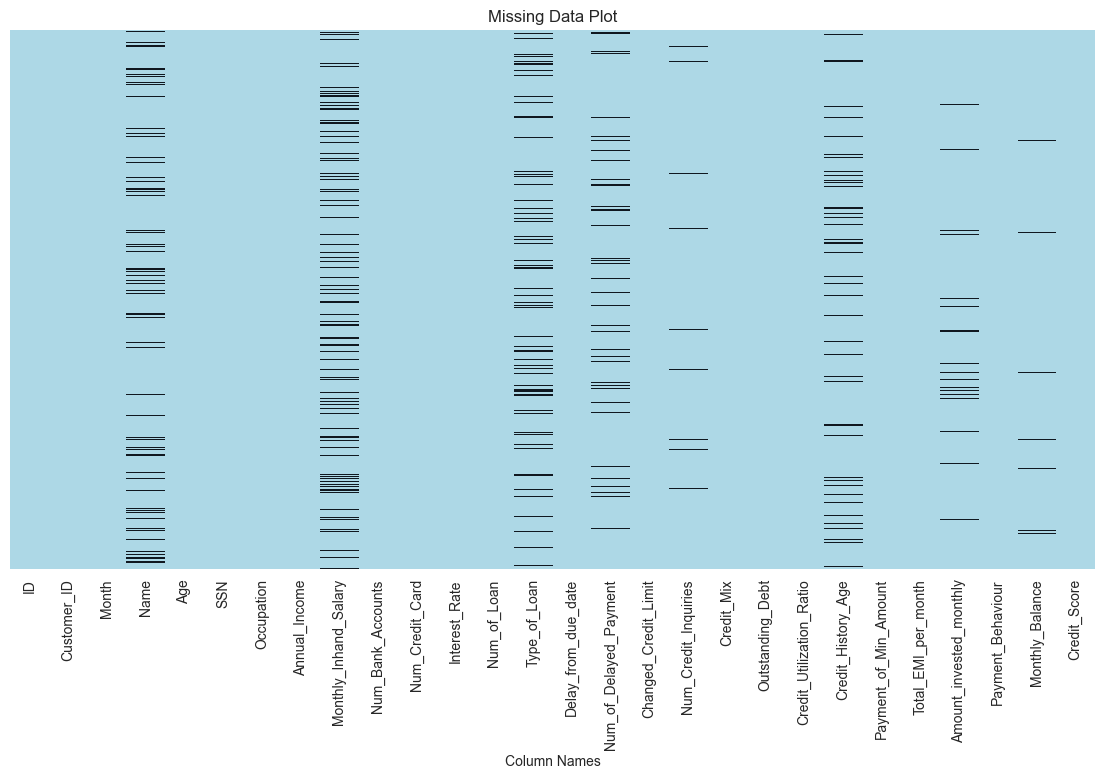

In [7]:
# Create a boolean dataframe where True indicates a missing value
missing = dataframe.isnull()

fig, ax = plt.subplots(figsize=(14, 7))

# Set the background color for the axis
ax.set_facecolor('#ADD8E6')

# Use seaborn to visualize the missing data with the desired colors
sns.heatmap(missing, cbar=False, yticklabels=False, cmap=['#ADD8E6', '#101820'], ax=ax)

# Set labels and title
ax.set_yticks([])
ax.set_xlabel('Column Names')
ax.set_title('Missing Data Plot')

plt.show()

---

# PLEASE ADD YOUR CODE HERE



---
<a id="5"></a>
<h3 class="content-header">5. Training a Prediction Model</h3>

<div class="markdown-container"> 
<ol>
<li>The dataset will be preprocessed in order to make it compatible with the existing machine learning model.</li>
<li>Training few machine learning models and evaluating them.</li>
<li>Evaluate best performing model and try to achieve more accuracy using the model.</li>

</ol>
</div>

<a id="5.1"></a>
<h3 class="content-header">5.1. Data Preprocessing for Prediction</h3>

<div class="markdown-container"> 
The cleaning process involes:
<ol>
<li>Converting all the values in a column to a single data type, either <strong>int</strong> or <strong>float</strong></li>
<li>Detecting outliers and then either replacing them with <strong>Mean/Median</strong> with respect to that particular customer or <strong>droping that row</strong>.</li>
<li>Applying <strong>OneHotEncoding</strong> to categorical Columns.</li>
<li>Using <strong>MinMaxScaler</strong> on continious numerical columns.</li>
</ol>
</div>

<h4 class="content-header">5.1.1 Month</h4>

In [8]:
encoded_months = pd.get_dummies(dataframe['Month'], prefix='Month')
dataframe = pd.concat([dataframe.drop('Month', axis=1), encoded_months], axis=1)

<h4 class="content-header">5.1.2 Age</h4>

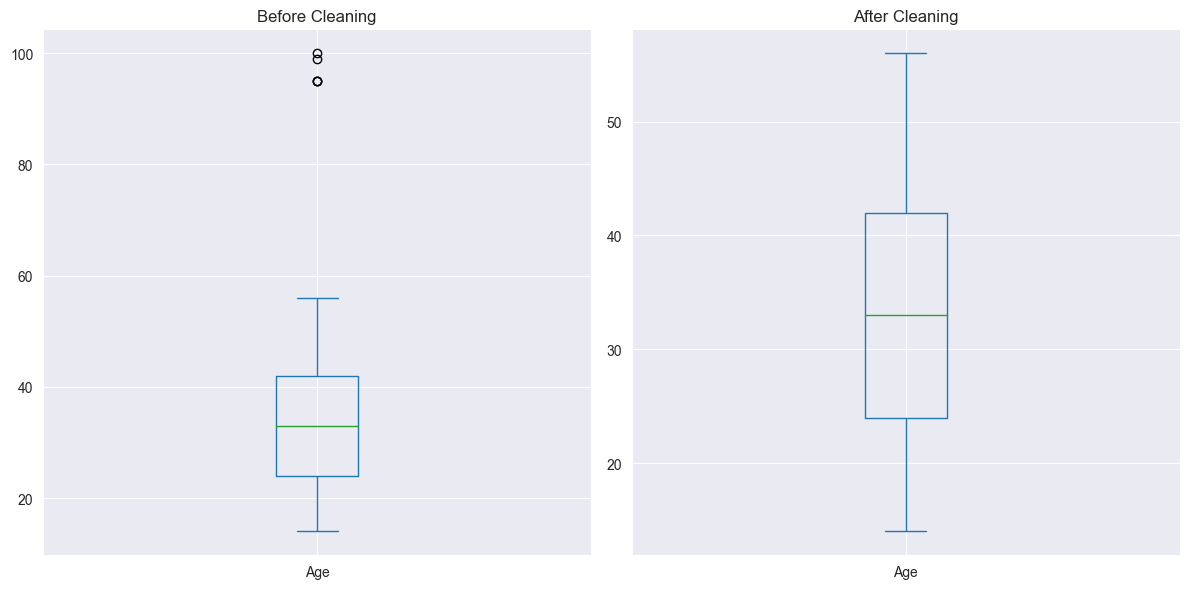

In [9]:
dataframe['Age'] = dataframe['Age'].apply(extract_int)
dataframe.loc[dataframe['Age'] > 100, 'Age'] = np.nan
medians = dataframe.groupby('Customer_ID')['Age'].transform('median')
dataframe['Age'].fillna(medians, inplace=True)
before = dataframe['Age']
dataframe = dataframe[dataframe['Age'] <= 60]
after = dataframe['Age']
plot_boxplot(before, after);

From the above boxplot, few outliers are visible, hence we will drop those age which are greater than ``60``

<h4 class="content-header">5.1.3 Occupation</h4>

In [10]:
dataframe['Occupation'].replace("_______", "Not_Specified", inplace=True)
encoded_occupations = pd.get_dummies(dataframe['Occupation'], prefix='Occupation')
dataframe = pd.concat([dataframe.drop('Occupation', axis=1), encoded_occupations], axis=1)

<h4 class="content-header">5.1.4 Annual_Income</h4>

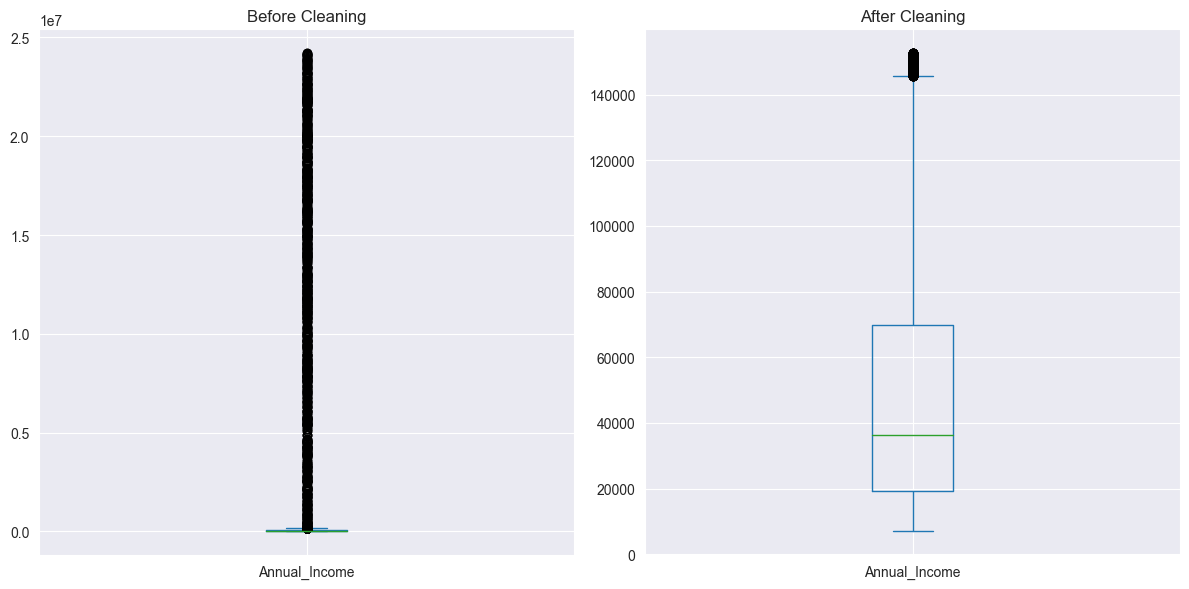

In [11]:
dataframe['Annual_Income'] = dataframe['Annual_Income'].apply(extract_float)
dataframe['Annual_Income'] = dataframe['Annual_Income'].astype('float64')
dataframe['Annual_Income'] = dataframe['Annual_Income'].round(2)
before = dataframe['Annual_Income']

# Dropping outliers, some of the annual salaries are around 24 million which is unusual. 
# There are approx 2000+ outliers. They may not be outliers, but they might affect the 
# model performance. Hence we decided to drop those rows.

# Calculate Q1, Q3, and IQR
Q1 = dataframe['Annual_Income'].quantile(0.25)
Q3 = dataframe['Annual_Income'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
dataframe = dataframe[(dataframe['Annual_Income'] >= lower_bound) & (dataframe['Annual_Income'] <= upper_bound)]
after = dataframe['Annual_Income']
plot_boxplot(before, after);

```Annual_Income``` values looks better now. According to boxplot still we see few number of outliers. This can be ignored as they are not realatively very high compared to other values.

<h4 class="content-header">5.1.5 Monthly_Inhand_Salary</h4>

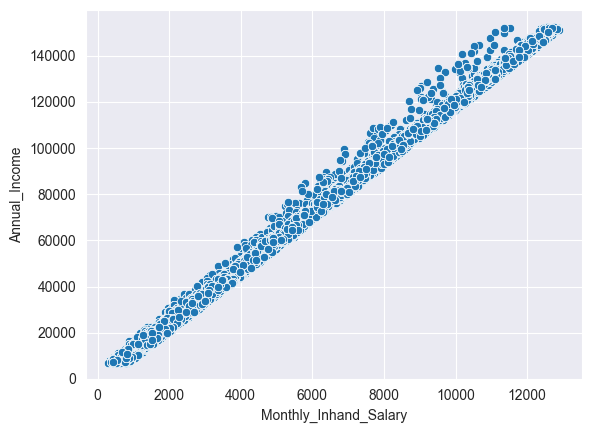

In [12]:
sns.scatterplot(x='Monthly_Inhand_Salary', y='Annual_Income', data=dataframe);

From the above plot it is evident that there is positive corelation between ``Monthly_Inhand_Salary`` and ``Annual_Income``. Hence we will apply linear regression to fill the missing nan values in the ``Monthly_Inhand_Salary`` column.

In [13]:
not_na = dataframe[dataframe['Monthly_Inhand_Salary'].notna()]
are_na = dataframe[dataframe['Monthly_Inhand_Salary'].isna()]

# Reshape data and train the model
X_train = not_na['Annual_Income'].values.reshape(-1, 1)
y_train = not_na['Monthly_Inhand_Salary']

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict the missing Monthly_Inhand_Salary values
X_test = are_na['Annual_Income'].values.reshape(-1, 1)
predicted_values = lr_model.predict(X_test)

# Fill the NaN values in the original dataframe with the predicted values
dataframe.loc[dataframe['Monthly_Inhand_Salary'].isna(), 'Monthly_Inhand_Salary'] = predicted_values

<h4 class="content-header">5.1.6 Num_Bank_Accounts</h4>

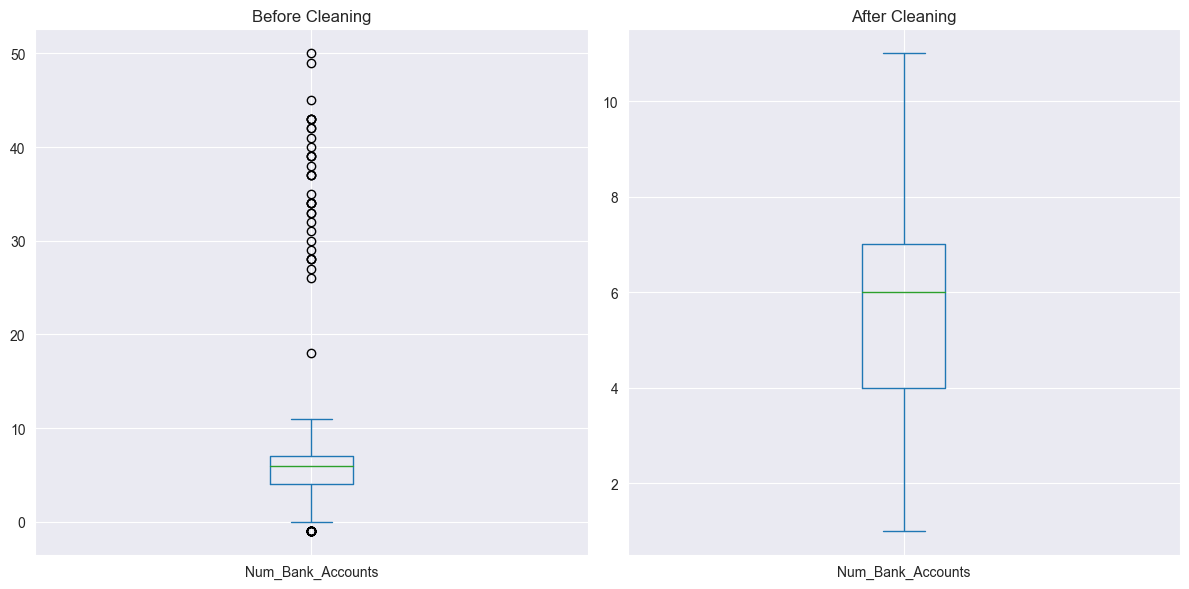

In [14]:
before = dataframe[dataframe['Num_Bank_Accounts'] <= 50]['Num_Bank_Accounts']
dataframe.loc[dataframe['Num_Bank_Accounts'] == 0, 'Num_Bank_Accounts'] = 1
dataframe.loc[dataframe['Num_Bank_Accounts'] < 0, 'Num_Bank_Accounts'] = np.nan
dataframe.loc[dataframe['Num_Bank_Accounts'] > 15, 'Num_Bank_Accounts'] = np.nan
medians = dataframe.groupby('Customer_ID')['Num_Bank_Accounts'].transform('median')
dataframe['Num_Bank_Accounts'].fillna(medians, inplace=True)
after = dataframe['Num_Bank_Accounts']
plot_boxplot(before, after);

Using the above box plot we will consider ``Num_Bank_Accounts > 15`` as an oulier and then try to fit a Median using Customer_ID.

<h4 class="content-header">5.1.7 Num_Credit_Card</h4>

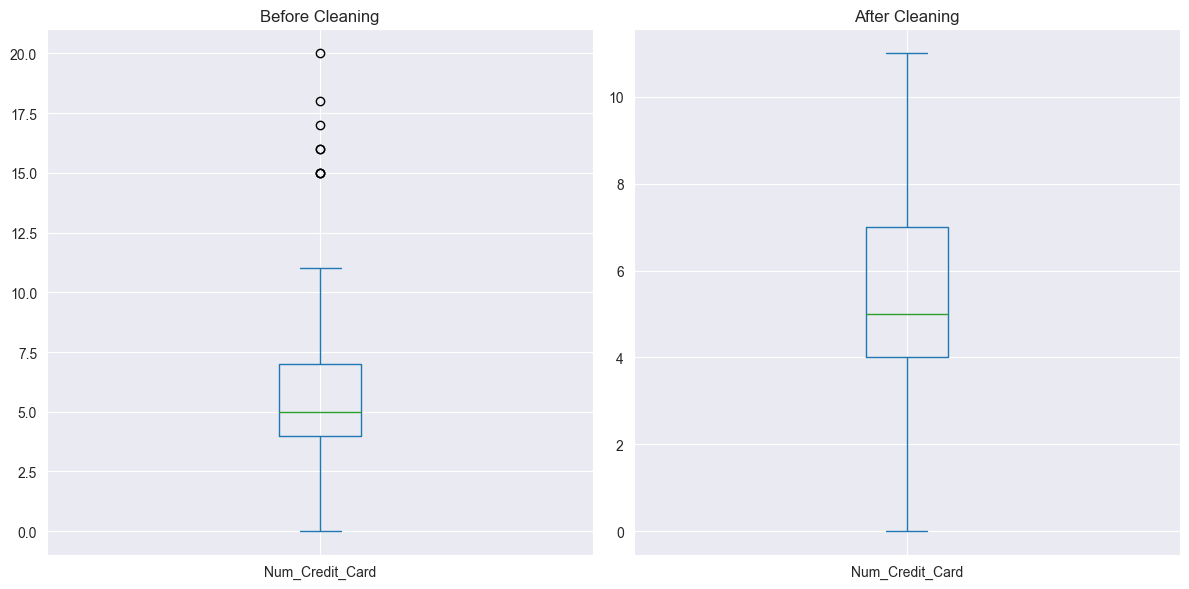

In [15]:
before = dataframe[dataframe['Num_Credit_Card'] <= 20]['Num_Credit_Card']
dataframe.loc[dataframe['Num_Credit_Card'] > 12, 'Num_Credit_Card'] = np.nan
medians = dataframe.groupby('Customer_ID')['Num_Credit_Card'].transform('median')
dataframe['Num_Credit_Card'].fillna(medians, inplace=True)
after = dataframe['Num_Credit_Card']
plot_boxplot(before, after);

Using the above box plot we will consider ``Num_Credit_Card > 12`` as an oulier and then try to fit a Median using Customer_ID.

<h4 class="content-header">5.1.8 Interest_Rate</h4>

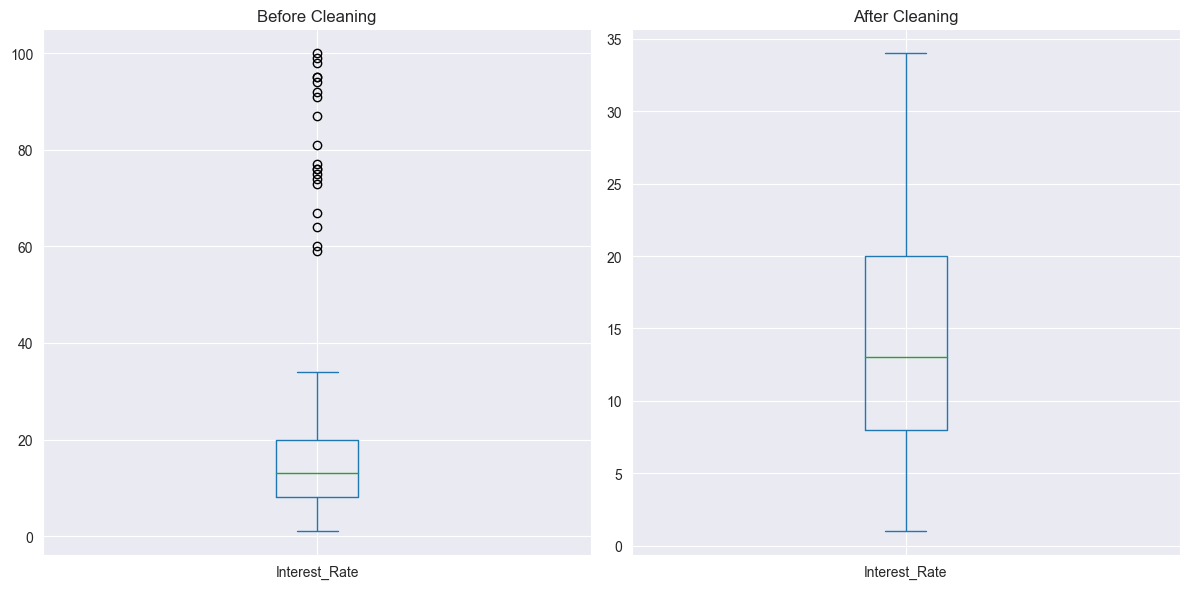

In [16]:
before = dataframe[dataframe['Interest_Rate'] <= 100]['Interest_Rate']
dataframe.loc[dataframe['Interest_Rate'] > 35, 'Interest_Rate'] = np.nan
medians = dataframe.groupby('Customer_ID')['Interest_Rate'].transform('median')
dataframe['Interest_Rate'].fillna(medians, inplace=True)
after = dataframe['Interest_Rate']
plot_boxplot(before, after);

Using the above box plot we will consider ``Interest_Rate > 35`` as an oulier and then try to fit a Median using Customer_ID.

<h4 class="content-header">5.1.9 Num_of_Loan</h4>

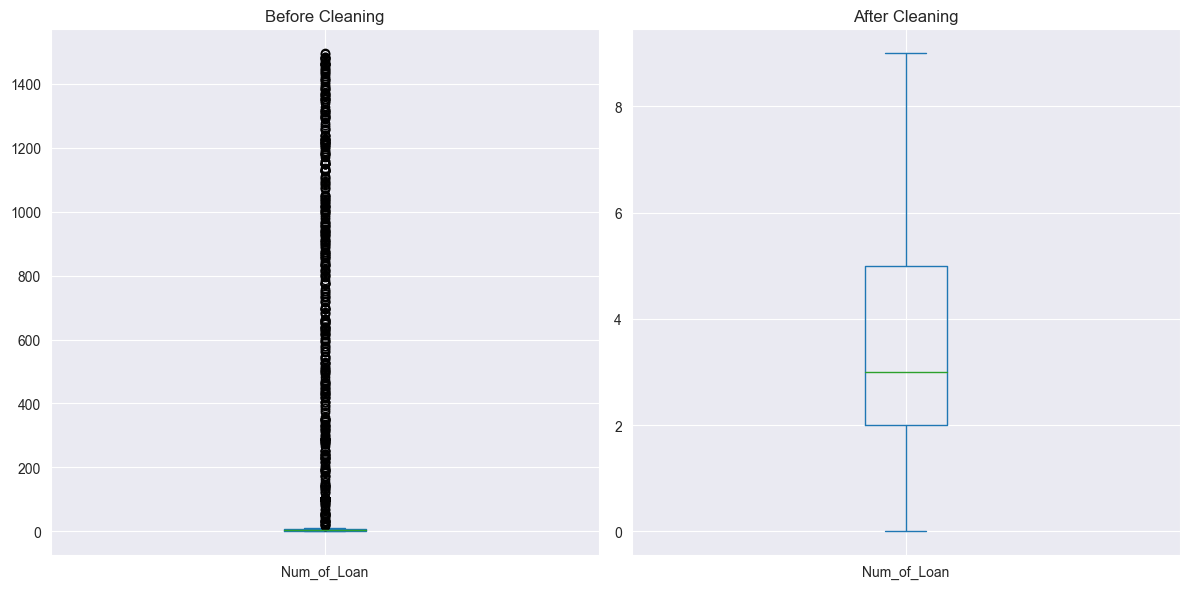

In [17]:
dataframe['Num_of_Loan'] = dataframe['Num_of_Loan'].apply(extract_int)
before = dataframe['Num_of_Loan']
dataframe.loc[dataframe['Num_of_Loan'] > 10, 'Num_of_Loan'] = np.nan
medians = dataframe.groupby('Customer_ID')['Num_of_Loan'].transform('median')
dataframe['Num_of_Loan'] = dataframe['Num_of_Loan'].fillna(medians)
after = dataframe['Num_of_Loan']
plot_boxplot(before, after);

Using the above box plot we will consider ``Num_of_Loan > 10`` as an oulier and then try to fit a Median using Customer_ID.

<h4 class="content-header">5.1.10 Type_of_Loan</h4>

In [18]:
# Find all the Unique types of loan
dataframe['Type_of_Loan'].fillna('Not Specified', inplace=True)

unique_loans = set()
for loan_string in dataframe['Type_of_Loan']:
    loans = loan_string.split(',')
    loans = [loan.strip() for subloan in loans for loan in subloan.split('and')]
    unique_loans.update(loans)
unique_loans.remove('')

# Create New Columns for the Type of Loan
for loan in unique_loans:
    dataframe[f'Type_of_Loan_{loan}'] = 0

# Fill number of occurrence in each column if the customer has taken a specific type of loan
for index, row in dataframe.iterrows():
    for loan in unique_loans:
        dataframe.at[index, f'Type_of_Loan_{loan}'] = row['Type_of_Loan'].count(loan)

# Dropping the original Column
dataframe.drop(columns=['Type_of_Loan'], inplace=True)

<h4 class="content-header">5.1.11 Num_of_Delayed_Payment</h4>

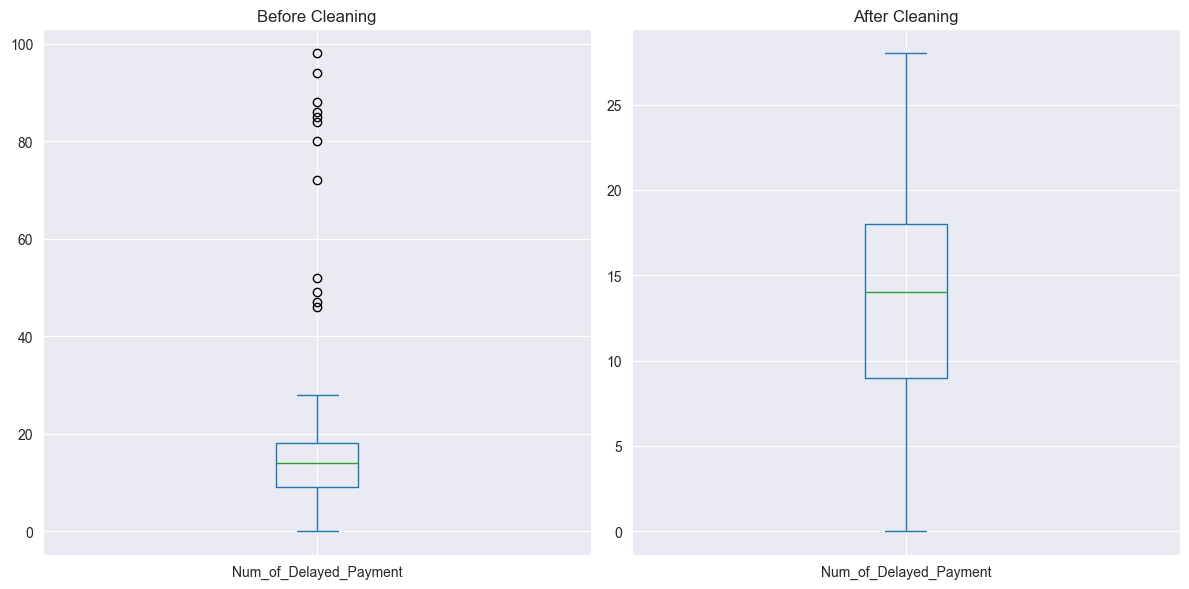

In [19]:
dataframe['Num_of_Delayed_Payment'] = dataframe['Num_of_Delayed_Payment'].apply(extract_int)
before = dataframe[dataframe['Num_of_Delayed_Payment'] <= 100]['Num_of_Delayed_Payment']
dataframe.loc[dataframe['Num_of_Delayed_Payment'] > 30, 'Num_of_Delayed_Payment'] = np.nan
medians = dataframe.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform('median')
dataframe['Num_of_Delayed_Payment'] = dataframe['Num_of_Delayed_Payment'].fillna(medians)
after = dataframe['Num_of_Delayed_Payment']
plot_boxplot(before, after);

Using the above box plot we will consider ``Num_of_Delayed_Payment > 30`` as an oulier and then try to fit a Median using Customer_ID.

<h4 class="content-header">5.1.12 Changed_Credit_Limit</h4>

In [20]:
dataframe['Changed_Credit_Limit'].replace("_", 0.0, inplace=True)
dataframe['Changed_Credit_Limit'] = dataframe['Changed_Credit_Limit'].astype('float32')

<h4 class="content-header">5.1.13 Num_Credit_Inquiries</h4>

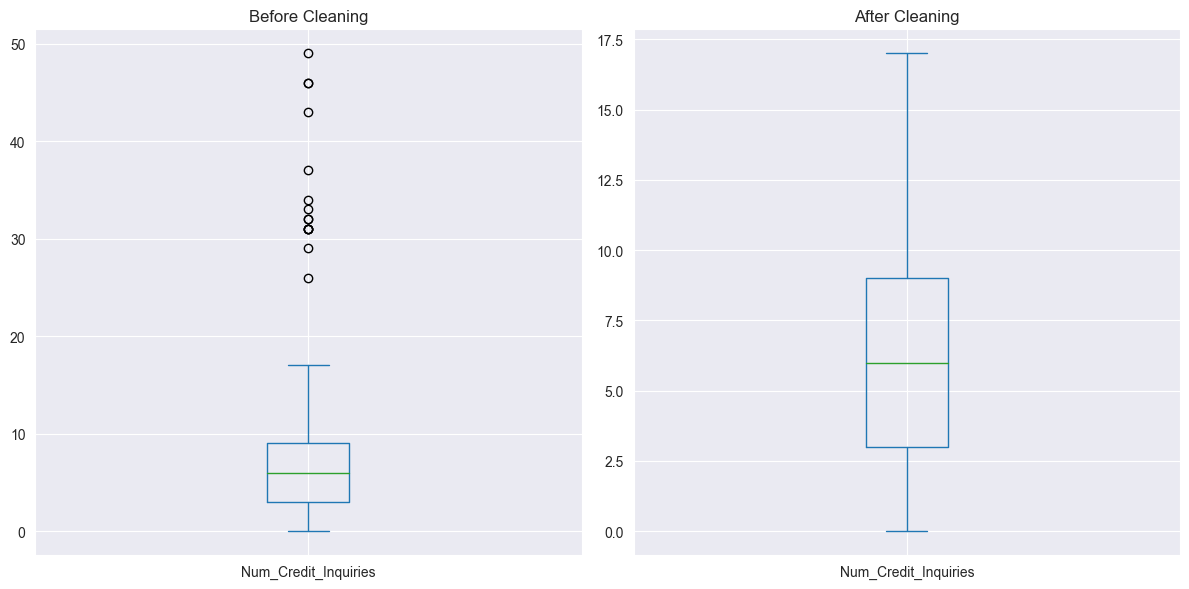

In [21]:
before = dataframe[dataframe['Num_Credit_Inquiries'] < 50]['Num_Credit_Inquiries']
dataframe.loc[dataframe['Num_Credit_Inquiries'] > 20, 'Num_Credit_Inquiries'] = np.nan
medians = dataframe.groupby('Customer_ID')['Num_Credit_Inquiries'].transform('median')
dataframe['Num_Credit_Inquiries'] = dataframe['Num_Credit_Inquiries'].fillna(medians)
after = dataframe['Num_Credit_Inquiries']
plot_boxplot(before, after);

<h4 class="content-header">5.1.14 Credit_Mix</h4>

In [22]:
credit_mix_map = {'_': np.nan, 'Bad': 0, 'Standard': 1, 'Good': 2}
dataframe['Credit_Mix'] = dataframe['Credit_Mix'].map(credit_mix_map)
medians = dataframe.groupby('Customer_ID')['Credit_Mix'].transform('median')
dataframe['Credit_Mix'] = dataframe['Credit_Mix'].fillna(medians)

<h4 class="content-header">5.1.15 Outstanding_Debt</h4>

In [23]:
dataframe['Outstanding_Debt'] = dataframe['Outstanding_Debt'].apply(extract_float)

<h4 class="content-header">5.1.16 Credit_History_Age</h4>

In [24]:
dataframe['Credit_History_Age'] = dataframe['Credit_History_Age'].apply(extract_months)
medians = dataframe.groupby('Customer_ID')['Credit_History_Age'].transform('median')
dataframe['Credit_History_Age'] = dataframe['Credit_History_Age'].fillna(medians)

<h4 class="content-header">5.1.17 Payment_of_Min_Amount</h4>

Payment_of_Min_Amount column has 3-Distinct values ``Yes``, ``No`` & ``NM``. We are assuming that ``NM`` means ``Not Mentioned``. So we will map the values of ``No to 0``, ``NM to 1`` & ``Yes to 2``.

In [25]:
payment_min_amt_map = {'No': 0, 'NM': 1, 'Yes': 2}
dataframe['Payment_of_Min_Amount'] = dataframe['Payment_of_Min_Amount'].map(payment_min_amt_map)

<h4 class="content-header">5.1.18 Total_EMI_per_month</h4>

This column's variation is very large. There are some customer who have actually make some high payment. But also we believe there are some values are very unusual and we need to replace them with the Median of the Customer Total_EMI_per_month. We will decide the maximum value of the Total_EMI_per_month using Mean and Standard Deviation.
$$
\text{Upper Bound} = \mu + 3 \times \sigma
$$

In [26]:
dataframe['Total_EMI_per_month'] = dataframe['Total_EMI_per_month'].round(2)
mean = dataframe['Total_EMI_per_month'].mean()
std = dataframe['Total_EMI_per_month'].std()
upper_bound = mean + 3*std

dataframe.loc[dataframe['Total_EMI_per_month'] > upper_bound, 'Total_EMI_per_month'] = np.nan
medians = dataframe.groupby('Customer_ID')['Total_EMI_per_month'].transform('median')
dataframe['Total_EMI_per_month'] = dataframe['Total_EMI_per_month'].fillna(medians)

<h4 class="content-header">5.1.19 Amount_invested_monthly</h4>

In [27]:
dataframe['Amount_invested_monthly'] = dataframe['Amount_invested_monthly'].apply(extract_float)
dataframe.loc[dataframe['Amount_invested_monthly'] > 1750, 'Amount_invested_monthly'] = np.nan
means = dataframe.groupby('Customer_ID')['Amount_invested_monthly'].transform('mean')
dataframe['Amount_invested_monthly'] = dataframe['Amount_invested_monthly'].fillna(means)
dataframe['Amount_invested_monthly'] = dataframe['Amount_invested_monthly'].round(2)

Using the above box plot we will consider ``Amount_invested_monthly > 1750`` as an oulier and then try to fit a Mean using Customer_ID.

<h4 class="content-header">5.1.20 Payment_Behaviour</h4>

In [28]:
dataframe['Payment_Behaviour'].replace("!@9#%8", "Not_Specified", inplace=True)
encoded_payment_behaviours = pd.get_dummies(dataframe['Payment_Behaviour'], prefix='PB')
dataframe = pd.concat([dataframe.drop('Payment_Behaviour', axis=1), encoded_payment_behaviours], axis=1)

<h4 class="content-header">5.1.21 Monthly_Balance</h4>

In [29]:
# There was only one bad value in this Column
dataframe['Monthly_Balance'].replace("__-333333333333333333333333333__", np.nan, inplace=True)

dataframe['Monthly_Balance'] = dataframe['Monthly_Balance'].astype('float64')
means = dataframe.groupby('Customer_ID')['Monthly_Balance'].transform('mean')
dataframe['Monthly_Balance'] = dataframe['Monthly_Balance'].fillna(means)
dataframe['Monthly_Balance'] = dataframe['Monthly_Balance'].round(2)

<h4 class="content-header">5.1.22 Credit_Score</h4>

In [30]:
credit_score_map = {'Poor': 0, 'Standard': 1, 'Good': 2}
dataframe['Credit_Score'] = dataframe['Credit_Score'].map(credit_score_map)

<h4 class="content-header">5.1.23 Dropping Unnecessary Columns</h4>

In [31]:
dataframe.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'], inplace=True)

<h4 class="content-header">5.1.24 Looking at the data after preprocessing</h4>

In [32]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97212 entries, 0 to 99999
Data columns (total 60 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   97212 non-null  float64
 1   Annual_Income                         97212 non-null  float64
 2   Monthly_Inhand_Salary                 97212 non-null  float64
 3   Num_Bank_Accounts                     97212 non-null  float64
 4   Num_Credit_Card                       97212 non-null  float64
 5   Interest_Rate                         97212 non-null  float64
 6   Num_of_Loan                           97212 non-null  float64
 7   Delay_from_due_date                   97212 non-null  int64  
 8   Num_of_Delayed_Payment                97212 non-null  float64
 9   Changed_Credit_Limit                  97212 non-null  float32
 10  Num_Credit_Inquiries                  97212 non-null  float64
 11  Credit_Mix          

In [33]:
dataframe.to_csv('Data/After_Feature_Engineering.csv', index=False)

<h4 class="content-header">5.1.25 Scaling and creating Train and Test Sets</h4>

In [34]:
X_df = dataframe.drop(columns=['Credit_Score'])
y_df = dataframe['Credit_Score']

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.30, random_state=100)

cols_to_scale = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 
                 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 
                 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

scaler = MinMaxScaler()
X_train_df[cols_to_scale] = scaler.fit_transform(X_train_df[cols_to_scale])
X_test_df[cols_to_scale] = scaler.transform(X_test_df[cols_to_scale])

X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values
y_test = y_test_df.values

---
<a id="5.2"></a>
<h3 class="content-header">5.2. Training and Evaluating Few Classification Models</h3>

<div class="markdown-container"> 
List of models:
<ol>
<li>LogisticRegression</li>
<li>XGBClassifier</li>
<li>RandomForestClassifier</li>
<li>KNeighborsClassifier</li>
</ol>
</div>

<h4 class="content-header">5.2.1 LogisticRegression</h4>

In [35]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
prediction = lr_model.predict(X_test)

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79     14444
           1       0.68      0.60      0.64      9713
           2       0.56      0.57      0.56      5007

    accuracy                           0.70     29164
   macro avg       0.67      0.66      0.66     29164
weighted avg       0.70      0.70      0.70     29164



<h4 class="content-header">5.2.2 XGBClassifier</h4>

In [36]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

prediction = xgb_model.predict(X_test)

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     14444
           1       0.79      0.76      0.78      9713
           2       0.71      0.71      0.71      5007

    accuracy                           0.81     29164
   macro avg       0.79      0.79      0.79     29164
weighted avg       0.81      0.81      0.81     29164



<h4 class="content-header">5.2.3 RandomForestClassifier</h4>

In [ ]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)
prediction = rfc_model.predict(X_test)

print(classification_report(y_test, prediction))

<h4 class="content-header">5.2.4 KNeighborsClassifier</h4>

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=15)
knn_model.fit(X_train, y_train)

prediction = knn_model.predict(X_test)

print(classification_report(y_test, prediction))

---
<a id="5.3"></a>
<h3 class="content-header">5.3. Plotting ROC Curve for each Model</h3>

In [ ]:
models = [
    lr_model,
    xgb_model,
    rfc_model,
    knn_model
]

model_names = [type(model).__name__ for model in models]

plot_roc_curve(models, model_names)

<div class="markdown-container"> 
The classification report shows that the RandomForestClassifier has an overall accuracy of 84%.
<br><br>
The ROC curve shows that the RandomForestClassifier has an AUC of 0.94 for class 0, AUC of 0.91 for class 1 and AUC of 0.94 for class 2, which is a very good score.
<br><br>
In conclusion, the RandomForestClassifier has provided the best results compared to other models. It has the highest accuracy, precision, recall, and AUC.
</div>

---
<a id="6"></a>
<h3 class="content-header">6. SHAP-driven Insights from RandomForest Classifier</h3>

# SHAP CODE GOES HERE

---
<a id="7"></a>
<h3 class="content-header">7. Conclusion</h3>

# Conclusion will be written after deriving insights from the SHAP Code

<h4 class="content-header">Thanks</h4>